# Curate acoustic data

Notebook within the chronic ephys processing pipeline
- 1-preprocess_acoustics
- **2-curate_acoustics**
- 3-sort_spikes
- 4-curate_spikes

Use the environment **songproc** to run this notebook

In [1]:
%matplotlib widget
import os
import numpy as np
import pandas as pd
import pickle
import IPython.display as ipd
import sys
sys.path.append('/mnt/cube/lo/envs/ceciestunepipe')
from ceciestunepipe.file import bcistructure as et
from ceciestunepipe.util.sound import boutsearch as bs
from ceciestunepipe.pipeline import searchbout as sb
from ceciestunepipe.mods import curate_bouts as cb

import logging
logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.WARNING) # set to logging.INFO if you'd like to see the full readout

## Set parameters

In [2]:
# session parameters
sess_par = {
    'bird':'z_b1w4_24', # bird ID
    'sess':'2024-11-13', # session date
    'ephys_software':'sglx', # recording software, sglx or oe
    'stim_sess':False, # if song stimulus was played during the session
    'stim_epoch':['2355_g0'],# mark all detections as song for these overnight epochs
    'trim_bouts':True, # manually trim bouts after curation
    'sort':'sort_0', # sort index
}

# set type of ALSA bout dataframe to load, depending on how far it's been previously processed
bout_df_type = 'auto' # options are 'auto' (not checked), 'checked' (checked not trimmed), and 'curated' (checked and trimmed)

## Load bouts captured through ADC channels in neural acquisition

In [3]:
# load bouts
hparams, bout_df = sb.load_bouts(sess_par['bird'],sess_par['sess'],'',
                                derived_folder='bouts_{}'.format(sess_par['ephys_software']),
                                bout_file_key='bout_sync_file')

# get sample rate and ensure same for all bouts
fs, bout_dicts_all = cb.epoch_bout_dict_sample_rate_check(bout_df, sess_par)

# if stim session, remove stim that overlap with bouts
bout_df_updated = bout_df.copy()
bout_df_updated = bout_df_updated.assign(bout_check=False, confusing=False, is_call=False)
# bout_df_updated = bout_df_updated.sort_values(by=['epoch', 'start_sample'])
if sess_par['stim_sess']:
    bout_df_updated.loc[bout_df_updated['epoch'].isin(sess_par['stim_epoch']), 'bout_check'] = True
    len_bouts = len(bout_df_updated[bout_df_updated['bout_check']==False])
    print('All bouts:',len(bout_df), '| Post stim removal:',len_bouts)
    try:
        first_bout = bout_df_updated[~bout_df_updated['epoch'].isin(sess_par['stim_epoch'])].index[0]
        last_bout = bout_df_updated[~bout_df_updated['epoch'].isin(sess_par['stim_epoch'])].index[-1]
        print('Bouts post stim removal begin at index',first_bout,'and end at index',last_bout)
    except: pass
else:
    len_bouts = len(bout_df)
    print('Bouts:',len(bout_df))

Bouts: 1698


## Load bouts captured through alsa
(Not doing anything with this yet, but could load bouts for the whole day and pair with SGLX session)

In [ ]:
# load bouts
bout_df_alsa = sb.load_bouts_alsa(sess_par['bird'], sess_par['sess'], bout_df_type)

# get sample rate and ensure same for all bouts
fs_alsa = cb.bout_fs_check(bout_df_alsa)

## Curate bouts
Review results of automatic bout detection algorithm to remove any false bout detections

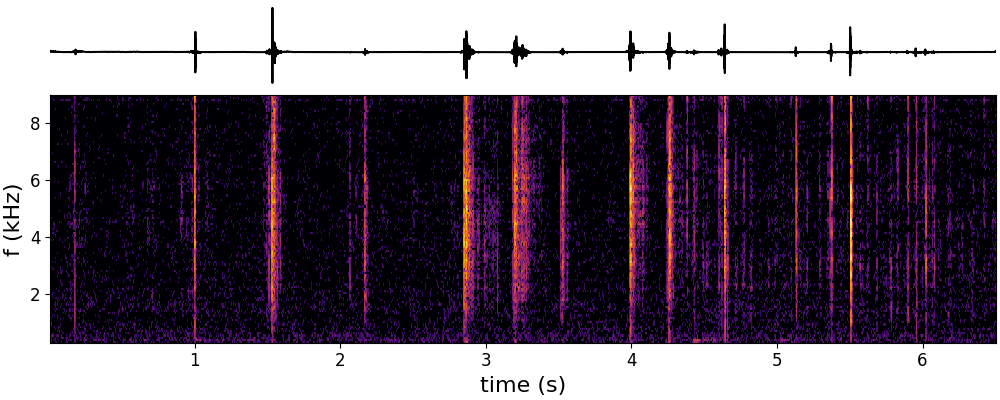

In [4]:
viz_bout = cb.VizBout(bout_df_updated, fs)

#### Option to listen to a bout

In [13]:
bout_idx = 510
ipd.Audio(bout_df_updated.iloc[bout_idx]['waveform'],rate=fs)

In [5]:
def duplicate_rows(df, rows_to_duplicate):
    
    rows_to_duplicate = sorted(rows_to_duplicate, reverse=True)
    
    for row_index in rows_to_duplicate:
        duplicated_row = df.iloc[[row_index]]
        df = pd.concat([
            df.iloc[:row_index + 1],
            duplicated_row,
            df.iloc[row_index + 1:]
        ]).reset_index(drop=True)
        
    return df

bout_df_updated = duplicate_rows(bout_df_updated,[520, 775, 848, 855, 1044])

In [6]:
# generate bout summaries
print(f"Out of {len(bout_df_updated.head(len_bouts))} potential bouts:")
print(f"• {bout_df_updated['bout_check'].head(len_bouts).sum() - bout_df_updated['is_call'].head(len_bouts).sum()} songs")
print(f"• {bout_df_updated['is_call'].head(len_bouts).sum()} calls")
print(f"• {len(bout_df_updated.head(len_bouts)) - bout_df_updated['bout_check'].head(len_bouts).sum()} noise")

Out of 1698 potential bouts:
• 379 songs
• 0 calls
• 1319 noise


## Trim bouts:
Now that you have only the true bouts, trim the start and end points to align precise with bout onset and offset. This will improve the performance of syllable segmentation and clustering in later steps.

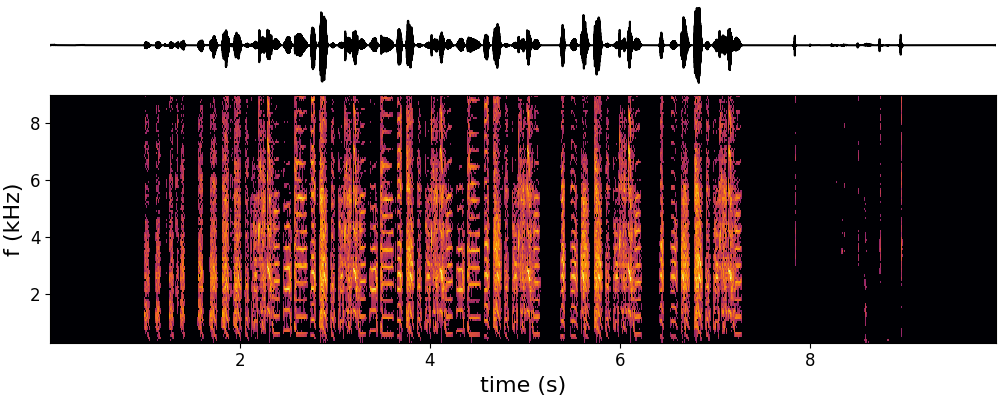

In [12]:
if sess_par['trim_bouts']:
    filtered_bout_df = bout_df_updated[(bout_df_updated['bout_check'] == True) & 
                                       (bout_df_updated['is_call'] == False)]
    if len(filtered_bout_df)>0:
        trim_bouts = cb.TrimBout(filtered_bout_df, fs)
    else:
        print('No bouts to trim...')
else:
    print('Skipping bout trimming..')

In [14]:
bout_idx = 4
ipd.Audio(filtered_bout_df.iloc[bout_idx]['waveform'],rate=fs)

In [7]:
# generate final bout df
if sess_par['trim_bouts']:
    if len(filtered_bout_df)>0:
        # pull out trim values
        start_s = trim_bouts.crop_min; end_s = trim_bouts.crop_max
        bout_df_final = cb.update_trimmed_bouts(filtered_bout_df, start_s, end_s, fs, fs_ap=30000)
    else:
        bout_df_final = filtered_bout_df
else:
    bout_df_final = viz_bout.bouts_pd.copy()

## Save curated acoustics

In [21]:
# save overall curated bout df
sb.save_auto_bouts(bout_df_final,sess_par,hparams,software=sess_par['ephys_software'],bout_file_key='bout_curated_file')

# loop through epochs - save curated data frames and dictionaries for each
for i,this_epoch in enumerate(np.unique(bout_df_final.epoch)):
    this_epoch_bout_df_final = bout_df_final.copy()
    epoch_struct = et.sgl_struct(sess_par,this_epoch,ephys_software=sess_par['ephys_software'])
    
    # get epoch bouts
    drop_condition = ~this_epoch_bout_df_final['file'].str.contains(this_epoch)
    this_epoch_bout_df_final.drop(this_epoch_bout_df_final[drop_condition].index, inplace=True)
    this_epoch_bout_df_final.reset_index(drop=True, inplace=True)
    
    # get bout dictionary
    this_bout_dict = bout_dicts_all[i]
    
    # update bout dictionary if necessary
    if sess_par['trim_bouts']:
        trim_keys = list(this_epoch_bout_df_final.keys()[this_epoch_bout_df_final.keys().str.contains('trim')])
        for this_key in trim_keys:
            this_bout_dict[this_key] = this_epoch_bout_df_final[this_key]
    
    # save curated bout dataframe and dictionary
    bout_dict_path = os.path.join(epoch_struct['folders']['derived'],'bout_dict_ap0_curated.pkl')
    with open(bout_dict_path, 'wb') as handle:
        pickle.dump(this_bout_dict, handle)
    bout_df_path = os.path.join(epoch_struct['folders']['derived'],'bout_pd_ap0_curated.pkl')
    this_epoch_bout_df_final.to_pickle(bout_df_path)

### Display bout times

In [22]:
times = []

for i, r in bout_df_final.iterrows():
    hr_start = int(r['file'][-19:-17])
    hr_end = hr_start
    mn = int(r['file'][-17:-15])
    
    mn_start = int(mn + r['start_ms'] / 60000)
    sec_start = int((mn + r['start_ms'] / 60000 - mn_start) * 60)
    while mn_start > 59:
        mn_start = mn_start - 60
        hr_start = hr_start + 1
    
    mn_end = int(mn + r['end_ms'] / 60000)
    sec_end = int((mn + r['end_ms'] / 60000 - mn_end) * 60)
    while mn_end > 59:
        mn_end = mn_end - 60
        hr_end = hr_end + 1
    
    times.append("{:02d}:{:02d}".format(hr_start, mn_start))

print(", ".join(times))

07:03, 07:05, 07:18, 07:22, 07:30, 07:31, 07:31, 07:31, 07:34, 07:46, 07:47, 07:47, 07:48, 07:49, 07:53, 07:54, 07:54, 07:56, 07:56, 07:56, 07:57, 07:58, 07:58, 07:58, 07:59, 08:00, 08:16, 08:17, 08:17, 08:17, 08:17, 08:18, 08:18, 08:18, 08:19, 08:19, 08:19, 08:22, 08:22, 08:23, 08:23, 08:33, 08:33, 08:33, 08:34, 08:37, 08:38, 08:43, 08:43, 08:44, 08:49, 08:49, 08:49, 08:49, 08:50, 08:50, 08:50, 08:50, 08:50, 08:51, 08:51, 08:51, 08:51, 08:52, 08:52, 08:52, 08:52, 08:52, 08:54, 08:54, 08:54, 08:54, 08:55, 08:59, 08:59, 08:59, 09:01, 09:01, 09:01, 09:01, 09:01, 09:01, 09:02, 09:02, 09:02, 09:14, 09:20, 09:21, 09:22, 09:23, 09:32, 09:36, 09:36, 09:36, 09:37, 09:37, 09:37, 09:37, 09:37, 09:47, 09:52, 09:52, 09:52, 09:52, 09:53, 09:54, 09:55, 09:55, 09:55, 09:55, 09:55, 09:55, 09:56, 09:56, 09:56, 09:56, 09:57, 09:57, 10:16, 10:18, 10:18, 10:18, 10:27, 10:29, 10:29, 10:37, 10:37, 10:38, 10:38, 10:38, 10:38, 10:38, 10:39, 10:39, 10:43, 10:43, 10:43, 10:44, 10:44, 10:44, 11:03, 11:03, 11:04,

In [34]:
count=1
for i, r in bout_df_final.iterrows():
#     if i > last_bout: break
    
    hr_start = int(r['file'][-19:-17])
    hr_end = hr_start
    mn = int(r['file'][-17:-15])
    
    mn_start = int(mn + r['start_ms']/60000)
    sec_start = int((mn + r['start_ms']/60000 - mn_start) * 60)
    while mn_start > 59:
        mn_start = mn_start-60
        hr_start = hr_start+1
    
    mn_end = int(mn + r['end_ms']/60000)
    sec_end = int((mn + r['end_ms']/60000 - mn_end) * 60)
    while mn_end > 59:
        mn_end = mn_end-60
        hr_end = hr_end+1
    
    if count > 361:
        print("{}. ".format(count-361),"{:02d}:{:02d}".format(hr_start, mn_start))
    
    count += 1

1.  15:21
2.  15:24
3.  15:30
4.  15:45
5.  15:45
6.  15:45
7.  15:45
8.  15:46
9.  15:52
10.  15:53
11.  15:54
12.  15:54
13.  15:54
14.  15:56
15.  15:57
16.  15:57
17.  15:58
18.  15:58


In [9]:
for i, r in bout_df_final.iterrows():
#     if i > last_bout: break
    
    hr_start = int(r['file'][-19:-17])
    hr_end = hr_start
    mn = int(r['file'][-17:-15])
    
    mn_start = int(mn + r['start_ms']/60000)
    sec_start = int((mn + r['start_ms']/60000 - mn_start) * 60)
    while mn_start > 59:
        mn_start = mn_start-60
        hr_start = hr_start+1
    
    mn_end = int(mn + r['end_ms']/60000)
    sec_end = int((mn + r['end_ms']/60000 - mn_end) * 60)
    while mn_end > 59:
        mn_end = mn_end-60
        hr_end = hr_end+1
    
    if i < 10:
        print("index {}:   ".format(i),"{}:{:02d}:{:02d} - {}:{:02d}:{:02d}".format(hr_start, mn_start, sec_start, hr_end, mn_end, sec_end), 
              " ({:.1f}s long)".format((r['end_ms']-r['start_ms'])/1000))
    elif i < 100:
        print("index {}:  ".format(i),"{}:{:02d}:{:02d} - {}:{:02d}:{:02d}".format(hr_start, mn_start, sec_start, hr_end, mn_end, sec_end), 
              " ({:.1f}s long)".format((r['end_ms']-r['start_ms'])/1000))
    else:
        print("index {}: ".format(i),"{}:{:02d}:{:02d} - {}:{:02d}:{:02d}".format(hr_start, mn_start, sec_start, hr_end, mn_end, sec_end), 
              " ({:.1f}s long)".format((r['end_ms']-r['start_ms'])/1000))

index 200:  8:15:19 - 8:15:27  (8.1s long)
index 201:  8:15:30 - 8:15:34  (3.8s long)
index 232:  8:20:31 - 8:20:36  (4.8s long)
index 265:  8:32:50 - 8:32:53  (3.8s long)
index 328:  8:54:26 - 8:54:30  (4.2s long)
index 332:  8:55:10 - 8:55:14  (4.3s long)
index 334:  8:55:38 - 8:55:43  (5.0s long)
index 363:  9:08:37 - 9:08:40  (2.8s long)
index 376:  9:13:39 - 9:13:43  (4.0s long)
index 377:  9:13:56 - 9:13:59  (2.9s long)
index 378:  9:14:15 - 9:14:19  (3.5s long)
index 380:  9:14:30 - 9:14:35  (4.4s long)
index 381:  9:14:41 - 9:14:46  (4.8s long)
index 383:  9:15:12 - 9:15:15  (2.7s long)
index 385:  9:15:24 - 9:15:27  (2.6s long)
index 388:  9:16:01 - 9:16:05  (3.5s long)
index 390:  9:16:39 - 9:16:42  (3.6s long)
index 391:  9:16:48 - 9:16:52  (3.3s long)
index 392:  9:16:57 - 9:17:01  (3.5s long)
index 393:  9:17:10 - 9:17:16  (5.3s long)
index 457:  9:35:02 - 9:35:05  (3.9s long)
index 458:  9:35:36 - 9:35:40  (3.6s long)
index 459:  9:36:01 - 9:36:04  (2.2s long)
index 460: 

## Concatenating sessions

In [4]:
exp_struct = et.get_exp_struct(sess_par['bird'],sess_par['sess'],sort=sess_par['sort'],ephys_software=sess_par['ephys_software'])
with open(os.path.join('/',*exp_struct['folders']['derived'].split('/')[:-1],'bouts_sglx','bout_curated.pickle'),'rb') as handle:
    bout_df_final = pickle.load(handle)

In [9]:
bout_df_final.tail(3)

,file,start_sample,end_sample,start_ms,end_ms,len_ms,waveform,fem_waveform,spectrogram,sample_rate,...,valid,start_ms_ap_0,start_sample_ap_0,start_sample_naive,bird,sess,epoch,bout_check,confusing,is_call
492,/mnt/cube/chronic_ephys/der/z_c7r3_24/2024-10-...,428690920,428890920,10717273,10722273,5000,"[526, 618, 631, 605, 761, 810, 683, 562, 428, ...","[-240, -246, -241, -223, -249, -235, -250, -23...","[[0.029080904690716187, 0.0, 0.0, 0.0, 0.0, 0....",40000,...,True,10717482,321521537,428690920,z_c7r3_24,2024-10-27,0959_g0,True,False,False
493,/mnt/cube/chronic_ephys/der/z_c7r3_24/2024-10-...,430589760,430737400,10764744,10768435,3691,"[430, 400, 415, 433, 409, 400, 398, 396, 462, ...","[-258, -269, -276, -275, -268, -289, -273, -26...","[[8.412246321385778e-05, 0.0, 0.0, 0.0, 0.0, 0...",40000,...,True,10764950,322945575,430589760,z_c7r3_24,2024-10-27,0959_g0,True,False,False
494,/mnt/cube/chronic_ephys/der/z_c7r3_24/2024-10-...,430804440,430951840,10770111,10773796,3685,"[683, 647, 694, 642, 631, 619, 660, 615, 643, ...","[-295, -303, -299, -306, -291, -290, -290, -28...","[[0.023815861020827486, 0.0, 0.0, 0.0, 0.0, 0....",40000,...,True,10770317,323106586,430804440,z_c7r3_24,2024-10-27,0959_g0,True,False,False


In [10]:
exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], ephys_software=sess_par['ephys_software'])
source_folder = exp_struct['folders']['derived']
wav_path_list = et.get_sgl_files_epochs(source_folder, file_filter='*wav_mic.{}'.format('npy'))

In [11]:
wav_path_list

['/mnt/cube/chronic_ephys/der/z_c7r3_24/2024-10-27/sglx/0658_g0/wav_mic.npy',
 '/mnt/cube/chronic_ephys/der/z_c7r3_24/2024-10-27/sglx/0959_g0/wav_mic.npy']

### First update all bout times

In [12]:
file_path = wav_path_list[0]
file_path

'/mnt/cube/chronic_ephys/der/z_c7r3_24/2024-10-27/sglx/0658_g0/wav_mic.npy'

In [13]:
npy_path = file_path.split('.')[0] + '.npy'
pkl_path = npy_path.split('.')[0] + '-npy_meta.pickle'
with open(pkl_path, 'rb') as fp:
    meta_dict = pickle.load(fp)
x = np.load(npy_path, mmap_mode='r').astype(meta_dict['dtype']).reshape(meta_dict['shape'])
s_f = meta_dict['s_f']

In [14]:
sample_offset = len(x)
sample_offset

432165153

In [15]:
ms_offset = round(len(x)/s_f*1000)
ms_offset

10804129

In [18]:
# loop through if stitching multiple recordings together
sample_offset = sample_offset + len(x)
ms_offset = ms_offset + round(len(x)/s_f*1000)

In [16]:
bout_df_new = bout_df_final.copy()

In [17]:
offset_idx = bout_df_new[bout_df_new['epoch']=='0959_g0'].index.tolist()
offset_idx

[324,
 326,
 371,
 375,
 377,
 378,
 383,
 416,
 417,
 418,
 419,
 420,
 421,
 424,
 432,
 434,
 435,
 457,
 462,
 463,
 465,
 466,
 470,
 471,
 475,
 478,
 479,
 480,
 481,
 482,
 483,
 484,
 485,
 486,
 489,
 490,
 491,
 492,
 493,
 494]

In [18]:
for i in offset_idx:
    bout_df_new.at[i, 'start_sample'] = bout_df_final.at[i, 'start_sample'] + sample_offset
    bout_df_new.at[i, 'end_sample'] = bout_df_final.at[i, 'end_sample'] + sample_offset
    bout_df_new.at[i, 'start_ms'] = bout_df_final.at[i, 'start_ms'] + ms_offset
    bout_df_new.at[i, 'end_ms'] = bout_df_final.at[i, 'end_ms'] + ms_offset

In [19]:
bout_df_new.tail(3)

,file,start_sample,end_sample,start_ms,end_ms,len_ms,waveform,fem_waveform,spectrogram,sample_rate,...,valid,start_ms_ap_0,start_sample_ap_0,start_sample_naive,bird,sess,epoch,bout_check,confusing,is_call
492,/mnt/cube/chronic_ephys/der/z_c7r3_24/2024-10-...,860856073,861056073,21521402,21526402,5000,"[526, 618, 631, 605, 761, 810, 683, 562, 428, ...","[-240, -246, -241, -223, -249, -235, -250, -23...","[[0.029080904690716187, 0.0, 0.0, 0.0, 0.0, 0....",40000,...,True,10717482,321521537,428690920,z_c7r3_24,2024-10-27,0959_g0,True,False,False
493,/mnt/cube/chronic_ephys/der/z_c7r3_24/2024-10-...,862754913,862902553,21568873,21572564,3691,"[430, 400, 415, 433, 409, 400, 398, 396, 462, ...","[-258, -269, -276, -275, -268, -289, -273, -26...","[[8.412246321385778e-05, 0.0, 0.0, 0.0, 0.0, 0...",40000,...,True,10764950,322945575,430589760,z_c7r3_24,2024-10-27,0959_g0,True,False,False
494,/mnt/cube/chronic_ephys/der/z_c7r3_24/2024-10-...,862969593,863116993,21574240,21577925,3685,"[683, 647, 694, 642, 631, 619, 660, 615, 643, ...","[-295, -303, -299, -306, -291, -290, -290, -28...","[[0.023815861020827486, 0.0, 0.0, 0.0, 0.0, 0....",40000,...,True,10770317,323106586,430804440,z_c7r3_24,2024-10-27,0959_g0,True,False,False


### Then update all IMEC times

In [20]:
ap_offset = 324127212

In [21]:
ap_sr = 29999.715740269356

In [22]:
ap_offset/ap_sr*1000

10804342.77465223

In [23]:
ap_ms_offset = round(ap_offset/ap_sr*1000)
ap_ms_offset

10804343

In [31]:
# loop through if stitching multiple recordings together
ap_offset = ap_offset + 320792334
ap_ms_offset = ap_ms_offset + round(320792334/ap_sr*1000)

In [24]:
bout_df_concat = bout_df_new.copy()

In [22]:
offset_idx = bout_df_new[bout_df_new['epoch']=='1001_g0'].index.tolist()
offset_idx

[369, 371, 373, 374, 388, 392, 401, 495, 515]

In [25]:
for i in offset_idx:
    bout_df_concat.at[i, 'start_sample_ap_0'] = bout_df_new.at[i, 'start_sample_ap_0'] + ap_offset
    bout_df_concat.at[i, 'start_ms_ap_0'] = bout_df_new.at[i, 'start_ms_ap_0'] + ap_ms_offset

In [26]:
bout_df_concat

,file,start_sample,end_sample,start_ms,end_ms,len_ms,waveform,fem_waveform,spectrogram,sample_rate,...,valid,start_ms_ap_0,start_sample_ap_0,start_sample_naive,bird,sess,epoch,bout_check,confusing,is_call
170,/mnt/cube/chronic_ephys/der/z_c7r3_24/2024-10-...,210190040,210422720,5254751,5260568,5817,"[576, 558, 542, 536, 548, 543, 489, 545, 530, ...","[-361, -354, -355, -366, -361, -369, -340, -35...","[[0.017511000482200115, 0.0, 0.0, 0.0, 0.0, 0....",40000,...,True,5254858,157644275,210190040,z_c7r3_24,2024-10-27,0658_g0,True,False,False
232,/mnt/cube/chronic_ephys/der/z_c7r3_24/2024-10-...,294687200,295054680,7367180,7376367,9187,"[1241, 1311, 1338, 1273, 1179, 1245, 1307, 133...","[-31, -44, -159, -145, -85, -95, -140, -197, -...","[[0.0, 0.08951110868089258, 0.0, 0.07497375802...",40000,...,True,7367329,221017795,294574680,z_c7r3_24,2024-10-27,0658_g0,True,False,False
237,/mnt/cube/chronic_ephys/der/z_c7r3_24/2024-10-...,300657480,300800680,7516437,7520017,3580,"[224, 231, 257, 248, 237, 201, 217, 203, 216, ...","[-329, -342, -351, -347, -354, -355, -350, -36...","[[0.0003291899535106133, 0.0, 0.0, 0.0, 0.0, 0...",40000,...,True,7516587,225495482,300610720,z_c7r3_24,2024-10-27,0658_g0,True,False,False
243,/mnt/cube/chronic_ephys/der/z_c7r3_24/2024-10-...,305995160,306175720,7649879,7654393,4514,"[778, 755, 826, 776, 763, 771, 761, 731, 758, ...","[-321, -322, -317, -318, -296, -305, -318, -31...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",40000,...,True,7650034,229498865,305895720,z_c7r3_24,2024-10-27,0658_g0,True,False,False
246,/mnt/cube/chronic_ephys/der/z_c7r3_24/2024-10-...,310836440,310935520,7770911,7773388,2477,"[289, 260, 320, 232, 273, 233, 256, 247, 204, ...","[-273, -259, -271, -270, -269, -289, -272, -26...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",40000,...,True,7771065,233129764,310730080,z_c7r3_24,2024-10-27,0658_g0,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,/mnt/cube/chronic_ephys/der/z_c7r3_24/2024-10-...,857666673,857746233,21441667,21443656,1989,"[555, 552, 574, 542, 612, 599, 605, 617, 601, ...","[-344, -385, -345, -348, -350, -357, -351, -34...","[[0.039103790884903136, 0.0, 0.0, 0.0, 0.0, 0....",40000,...,True,21442089,643256701,425492520,z_c7r3_24,2024-10-27,0959_g0,True,False,False
491,/mnt/cube/chronic_ephys/der/z_c7r3_24/2024-10-...,859237353,859435833,21480934,21485896,4962,"[407, 385, 406, 416, 403, 392, 388, 381, 360, ...","[-223, -224, -230, -234, -239, -234, -236, -24...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",40000,...,True,21481351,644434551,427072200,z_c7r3_24,2024-10-27,0959_g0,True,False,False
492,/mnt/cube/chronic_ephys/der/z_c7r3_24/2024-10-...,860856073,861056073,21521402,21526402,5000,"[526, 618, 631, 605, 761, 810, 683, 562, 428, ...","[-240, -246, -241, -223, -249, -235, -250, -23...","[[0.029080904690716187, 0.0, 0.0, 0.0, 0.0, 0....",40000,...,True,21521825,645648749,428690920,z_c7r3_24,2024-10-27,0959_g0,True,False,False
493,/mnt/cube/chronic_ephys/der/z_c7r3_24/2024-10-...,862754913,862902553,21568873,21572564,3691,"[430, 400, 415, 433, 409, 400, 398, 396, 462, ...","[-258, -269, -276, -275, -268, -289, -273, -26...","[[8.412246321385778e-05, 0.0, 0.0, 0.0, 0.0, 0...",40000,...,True,21569293,647072787,430589760,z_c7r3_24,2024-10-27,0959_g0,True,False,False


In [27]:
bout_df_concat.to_pickle('/mnt/cube/chronic_ephys/der/z_c7r3_24/2024-10-27/sglx/0658_g0-0959_g0/bout_pd_ap0_curated.pkl')